# Extensions to the ice sheet model 

1. define the model as a function, so that we can run it multiple times with different parameters
2. allow a time varying forcing 
3. Allow the bed to vary

## 1. define the model as a function

The cell below collects the code from all the cells above (except the code which plotted things for visualization purposes) in to one cell. 

It also defines a function called `sia`, which takes as inputs various model parameters and outputs $H(x,t), x, t, $ and $q(x,T)$. 

The inputs are given default values, so if you do not define them the function uses the default values. The simplest way to call the function is with default parameters using `sia()`. 

To keep the results use
`H, x, t, q_final = sia()`

By default the function plots a summary of the results. To prevent plotting use
`H, x, t, q_final = sia(plot = False)`

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def sia(A = 24*10**(-25) * 365*24*60*60,
        T = 3000,
        dt = 0.004,
        dx = 200,
        X = 40000,
        b0 = 10**(-4), 
        elx = 1/3,
        plot = True,
        print_period = 30000):

    
    
    t = np.linspace(0,T,round(T/dt))  # the time grid, units [years]
    Lt = t.size                       # record the length of the time grid for use later

    x = np.linspace(0,X,round(X/dx))  # spatial grid, units [m]
    Lx = x.size                       # record the length of the spatial grid for use later


    x_stag = x[0:-1] + 0.5*dx

    n = 3.0                              # The flow law exponent
    rho = 917                            # ice density,  units [kg/m^3]
    g = 10                               # acceleration due to gravity, units [m/s^2]
    e = 0.0001  

    H = np.zeros((Lt,Lx))             # pre-allocate the H array

    H[0,:] = e                        # define initial conditions for H
     
    b = b0 * (X*elx-x)                # define SMB
    

    ### the main loop
    for timestep in np.arange(1,Lt):

        # only print a message when the remainder of the timestep number and `print_period` is zero. i.e. if print_period = 30000, this prints a message very 30,000th timestep.
        if timestep % print_period == 0:    
            print(f'{t[timestep]:.1f} out of {T} years')

        # save the old thickness vector
        H_old  = H[timestep-1,:]

        # (1) compute H on the staggered grid
        H_stag = (H_old[1:] + H_old[:-1])/2

        # (2) compute the surface slope on the staggered grid.
        alpha = -(H_old[1:] - H_old[:-1])/dx 

        # (3) compute the flux on the staggered grid
        q = 2*A/(n+2) * (rho * g * alpha)**n * H_stag**(n+2)  

        # (4) compute the ice thickness at the current time step
        H[timestep,1:-1] = np.maximum(e, H_old[1:-1] + dt * ( b[1:-1] - (q[1:]-q[0:-1])/dx ))    
 
        # apply the boundary conditions at x = 0 and x = X
        H[timestep,0] = H[timestep,1]
        H[timestep,-1] = e

 
    
    
    # plot unless plot == False
    if plot:
        fig,ax = plt.subplots(ncols=2, figsize=(20,10))
        
        ax[0].plot(x,np.transpose(H[0:-1:print_period,:]), label = 'surface');
        ax[0].set_xlabel('distance, $x$ [m]')
        ax[0].set_ylabel('ice thickness, $H(x)$ [m]')

        ax[1].plot(t,np.transpose(H[:,0]), '.', label = 'ice divide height');
        ax[1].set_xlabel('time, $t$ [years]')
        ax[1].set_ylabel('ice surface height at the left of the domain, $z_s(x=0,t)$ [m]')

        
        plt.show()
     
    return H, x, t, q

We can run the simulation with a lower value of the ice-flow parameter $A$. This should make the ice stiffer. 

120.0 out of 200 years


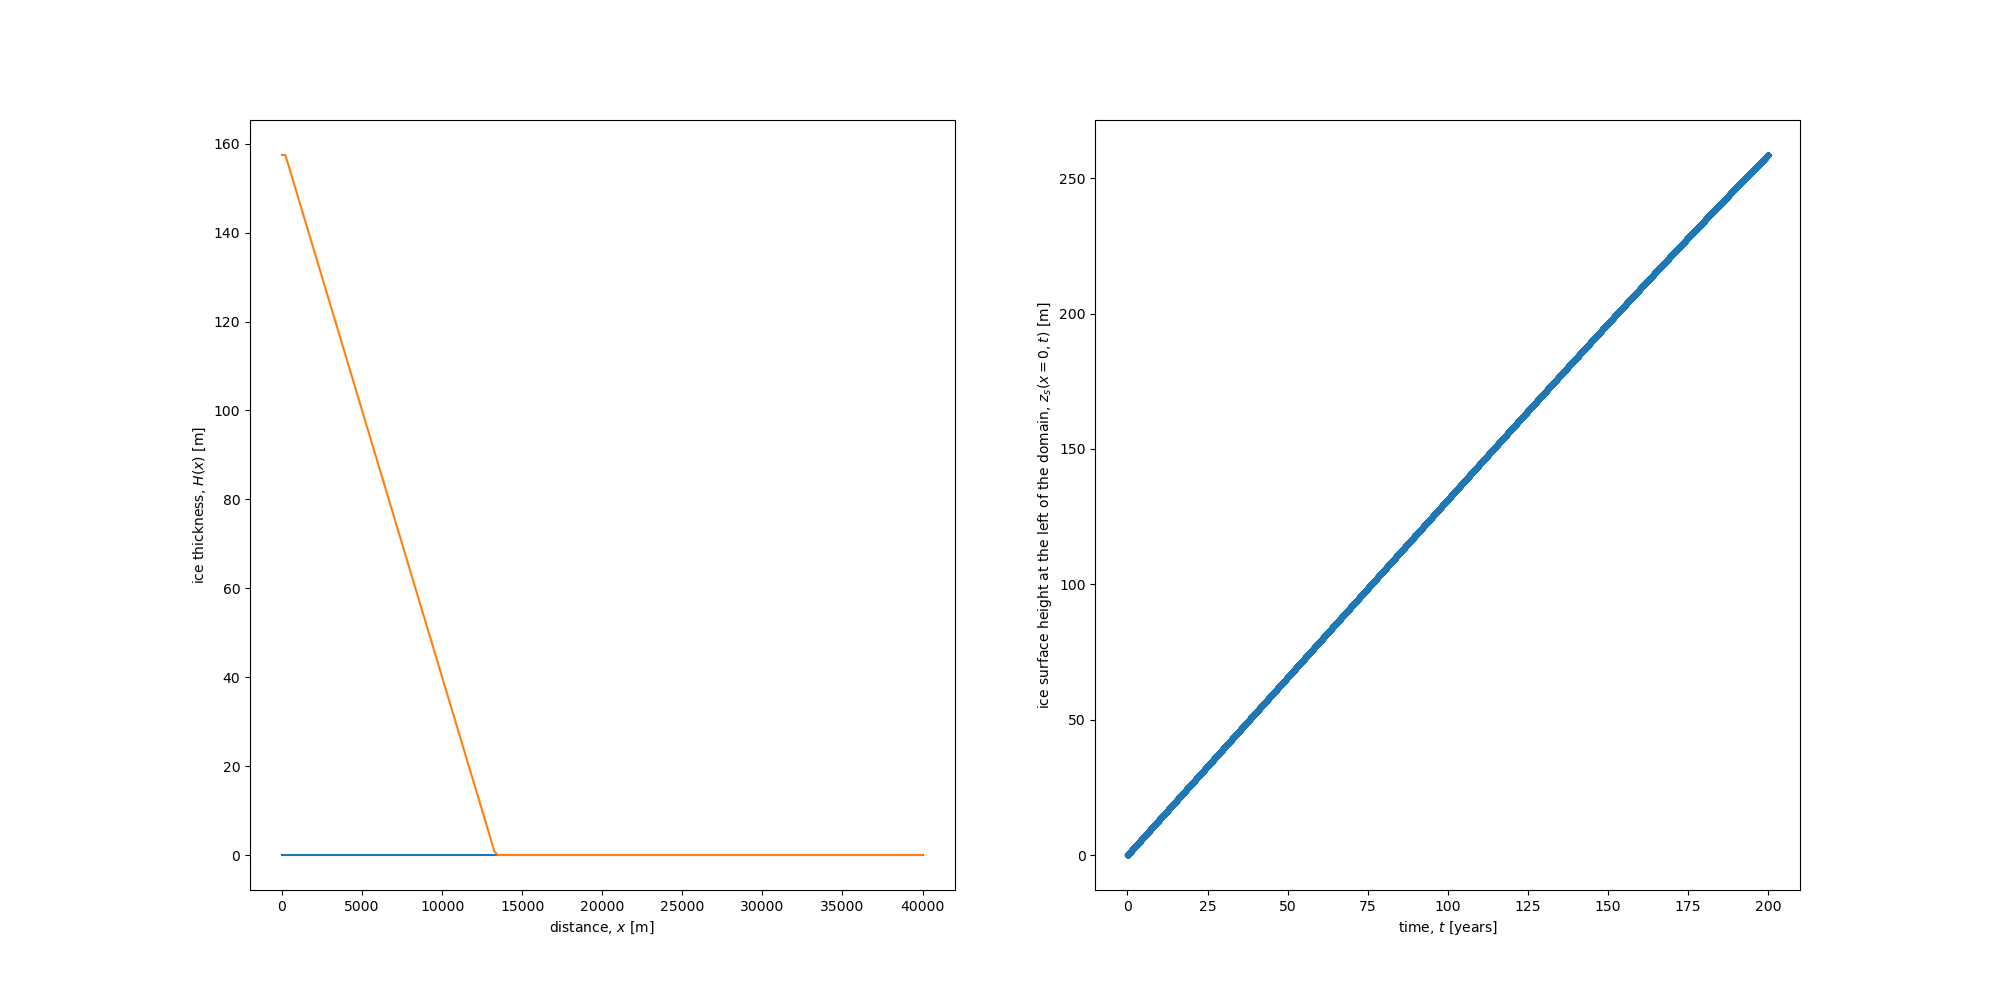

In [30]:
H_low_A, x, t, q_final_low_A  = sia(T = 200, A = 12*10**(-25) * 365*24*60*60)

### Define the animation code.
The cell below Use this code to plot an animation of your model results. 


In [39]:
# imports you may need to import 
%matplotlib widget
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')

def animate_ice_model_results(x, t, f, interval_between_timesteps = 5000, time_delay_between_frames = 100):
    ## run this function by, e.g., `animate_ice_model_results(x, t, zs)`

    # open a figure and an axes inside the figure
    fig, ax = plt.subplots()

    # set the limits of the axes
    ax.set_xlim(( x[0], x[-1]))    # the horizontal axis will go from 0 to X
    ax.set_ylim((np.min(f), np.max(f)))   # the vertical axis will got from the lowest point on the bed, to the highest 

    # create an line object with no data, and suppress the plot 
    line, = ax.plot([], [], lw=2)
    plt.close()

    # define a function which updates the figure, given a timestep number. This function plots the line and updates the axis labels. 
    def animate(timestep):
        line.set_data(x, f[timestep,:])                 # update the data
        ax.set_title(f"$t$ = {t[timestep]:.1f} years")  # update the title
        ax.set_xlabel("distance, $x$ [m]")              # update the x label
        ax.set_ylabel("ice surface height, $z_s$ [m]")  # update the y label, change this if you want to plot something other than ice surface height
        return line

    # setup the animation 
    anim = animation.FuncAnimation(fig, animate, 
                                   frames = np.arange(0, len(t), interval_between_timesteps),
                                   interval = time_delay_between_frames, 
                                   blit = True)
    
    return anim
   


Plot the animation

In [15]:
animate_ice_model_results(x, t, H_low_A)

IndexError: index 750000 is out of bounds for axis 0 with size 750000

Comparing these plots to the plots we got from running the model initially with the default value of $A$, we see that the final (or near final) ice thickness is larger than when $A$ is smaller. 

Now we can loop over values of $A$ recording the ice thickness at the ice divide. 

A = 6.3072e-18
400.0 out of 3000 years
800.0 out of 3000 years
1200.0 out of 3000 years
1600.0 out of 3000 years
2000.0 out of 3000 years
2400.0 out of 3000 years
2800.0 out of 3000 years
A = 2.9959200000000006e-17
400.0 out of 3000 years
800.0 out of 3000 years
1200.0 out of 3000 years
1600.0 out of 3000 years
2000.0 out of 3000 years
2400.0 out of 3000 years
2800.0 out of 3000 years
A = 5.36112e-17
400.0 out of 3000 years
800.0 out of 3000 years
1200.0 out of 3000 years
1600.0 out of 3000 years
2000.0 out of 3000 years
2400.0 out of 3000 years
2800.0 out of 3000 years
A = 7.72632e-17
400.0 out of 3000 years
800.0 out of 3000 years
1200.0 out of 3000 years
1600.0 out of 3000 years
2000.0 out of 3000 years
2400.0 out of 3000 years
2800.0 out of 3000 years
A = 1.009152e-16
400.0 out of 3000 years
800.0 out of 3000 years
1200.0 out of 3000 years
1600.0 out of 3000 years
2000.0 out of 3000 years
2400.0 out of 3000 years
2800.0 out of 3000 years


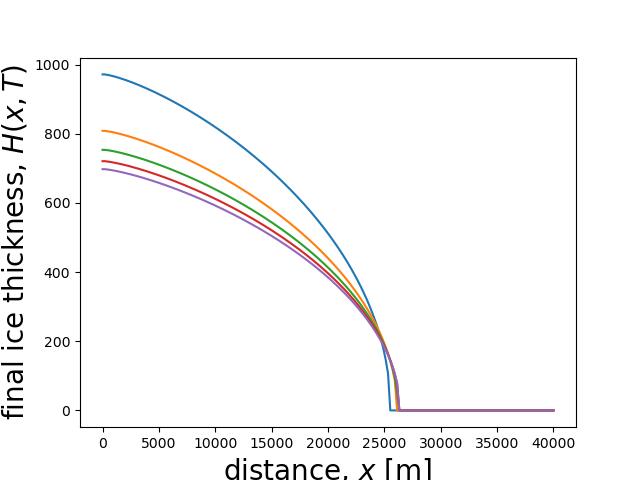

In [42]:
A_vector = np.linspace(2,32,5)*10**(-25) * 365*24*60*60
model_metric = []
i = 0
plt.figure()
for A in A_vector:
    print(f"A = {A}")
    H, x, t, q_final = sia(T = 3000, plot = False, print_period = 1e5, A = A)
    model_metric.append(H[-1,0])
    
    
    plt.plot(x,H[-1,:]);
    plt.xlabel('distance, $x$ [m]', size = 20)
    plt.ylabel('final ice thickness, $H(x,T)$', size = 20)
    
    i = i+1

Text(0, 0.5, 'Ice divide thickness $H(0,T)$, [m]')

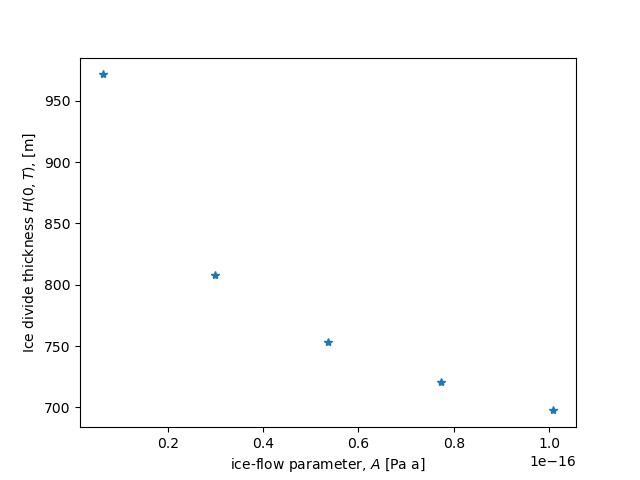

In [44]:
fig,ax = plt.subplots(ncols=1)
        
ax.plot(A_vector, model_metric, '*');
ax.set_xlabel('ice-flow parameter, $A$ [Pa a]')
ax.set_ylabel('Ice divide thickness $H(0,T)$, [m]')


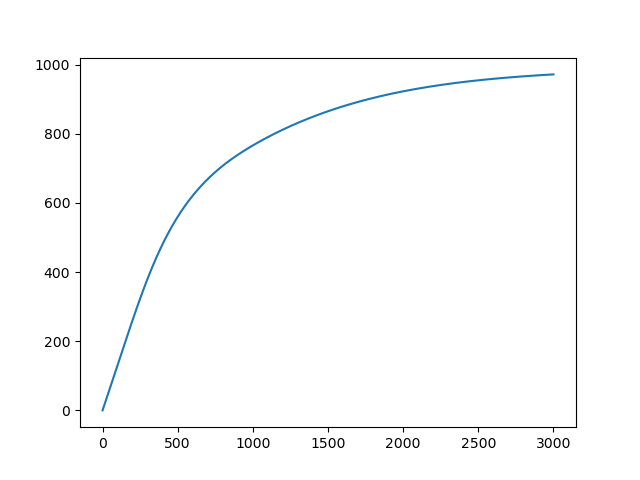

In [22]:
#H, x, t, q_final = sia(T = 3000, plot = False, print_period = 1e5, A = A_vector[0])
fig,ax = plt.subplots(ncols=1)
        
ax.plot(t,H[:,0]);
#ax.set_xlabel('ice-flow parameter, $A$ [Pa a]')
#ax.set_ylabel('Ice divide thickness $H(0,T)$, [m]')

#plt.plot()

## 2. Allow a time varying forcing

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sia_time_varying(A = 24*10**(-25) * 365*24*60*60,
       T = 3000,
       dt = 0.004,
       dx = 200,
       X = 40000,
       b0 = 10**(-4), 
       elx = 1/3,
       plot = True,
       print_period = 30000,
       period = 1000,
       amplitude = 0):

    t = np.linspace(0,T,round(T/dt))  # the time grid, units [years]
    Lt = t.size                       # record the length of the time grid for use later

    x = np.linspace(0,X,round(X/dx))  # spatial grid, units [m]
    Lx = x.size                       # record the length of the spatial grid for use later


    x_stag = x[0:-1] + 0.5*dx

    n = 3.0                              # The flow law exponent
    rho = 917                            # ice density,  units [kg/m^3]
    g = 10                               # acceleration due to gravity, units [m/s^2]
    e = 0.0001  

    H = np.zeros((Lt,Lx))             # pre-allocate the H array

    H[0,:] = e                        # define initial conditions for H 
    
    #elx_variability = X*elx*amplitude * np.cos(2 * np.pi * t/period) 
    elx_variability = amplitude * np.cos(2 * np.pi * t/period) 


    ### the main loop
    for timestep in np.arange(1,Lt):

        # only print a message when the remainder of the timestep number and `print_period` is zero. i.e. if print_period = 30000, this prints a message very 30,000th timestep.
        if timestep % print_period == 0:    
            print(f'{t[timestep]:.1f} out of {T} years')

        # save the old thickness vector
        H_old  = H[timestep-1,:]

        # (1) compute H on the staggered grid
        H_stag = (H_old[1:] + H_old[:-1])/2

        # (2) compute the surface slope on the staggered grid.
        alpha = -(H_old[1:] - H_old[:-1])/dx 

        # (3) compute the flux on the staggered grid
        q = 2*A/(n+2) * (rho * g * alpha)**n * H_stag**(n+2)  

        # compute b
        b = b0 * (  X*elx*(1 + elx_variability[timestep])  -  x  ) 
        
        # (4) compute the ice thickness at the current time step
        H[timestep,1:-1] = np.maximum(e, H_old[1:-1] + dt * ( b[1:-1]  - (q[1:]-q[0:-1])/dx ))    
 
        # apply the boundary conditions at x = 0 and x = X
        H[timestep,0] = H[timestep,1]
        H[timestep,-1] = e

    # save the flux
    q_final = q
    
    
    # plot unless plot == False
    if plot:
        fig,ax = plt.subplots(ncols=3, figsize=(20,10))
        
        ax[0].plot(x,np.transpose(H[0:-1:print_period,:]), label = 'surface');
        ax[0].set_xlabel('distance, $x$ [m]')
        ax[0].set_ylabel('ice thickness, $H(x)$ [m]')

        ax[1].plot(t[0:-1:print_period],np.transpose(H[0:-1:print_period,0]), label = 'ice divide height');
        ax[1].set_xlabel('time, $t$ [years]')
        ax[1].set_ylabel('ice surface height at the left of the domain, $z_s(x=0,t)$ [m]')
        
        ax[2].plot(t[0:-1:print_period],np.transpose(elx_variability[0:-1:print_period]), label = 'equilibrium line position');
        ax[2].set_xlabel('time, $t$ [years]')
        ax[2].set_ylabel('elx_variability [m]')
        
     
    return H, x, t, q_final, elx_variability

300.0 out of 4000 years
600.0 out of 4000 years
900.0 out of 4000 years
1200.0 out of 4000 years
1500.0 out of 4000 years
1800.0 out of 4000 years
2100.0 out of 4000 years
2400.0 out of 4000 years
2700.0 out of 4000 years
3000.0 out of 4000 years
3300.0 out of 4000 years
3600.0 out of 4000 years
3900.0 out of 4000 years


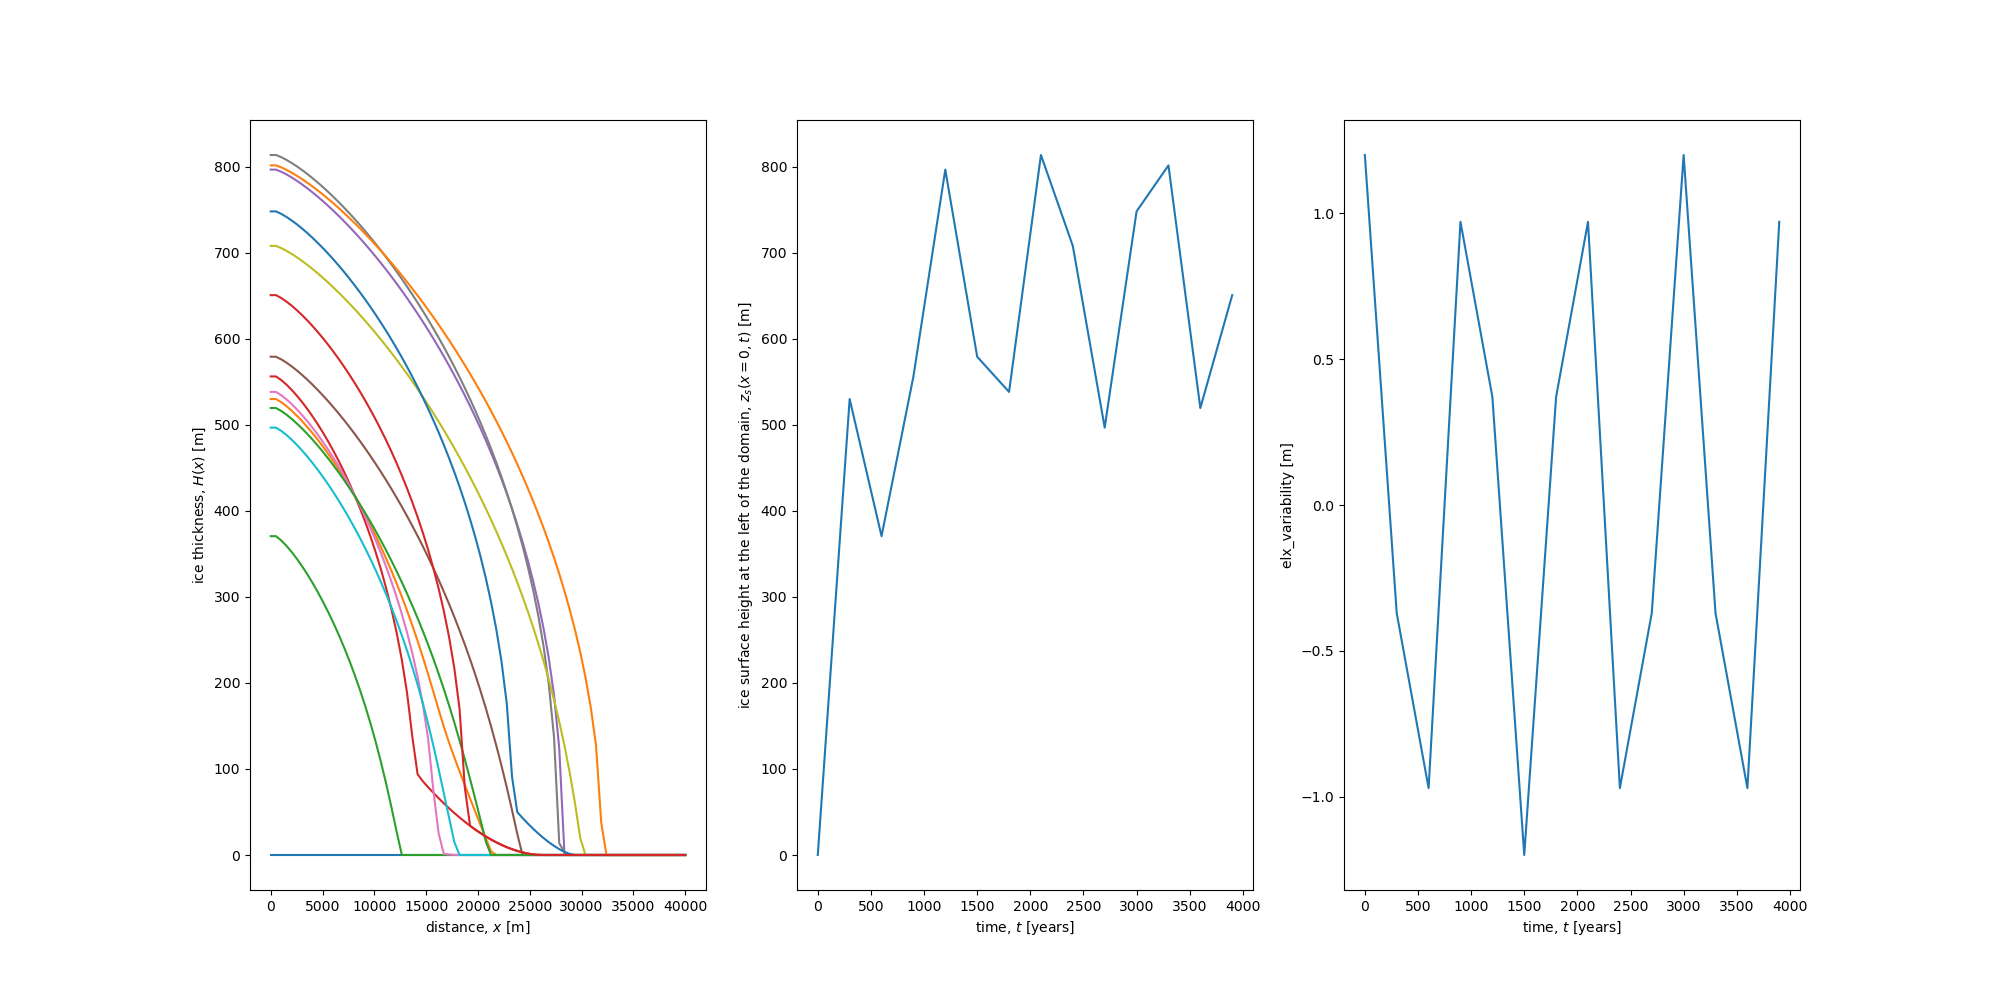

In [5]:
H_varying_t, x, t, q_varying_t, elx_variability = sia_time_varying(T=4000, amplitude = 1.2, dx = 500, dt = 0.01)

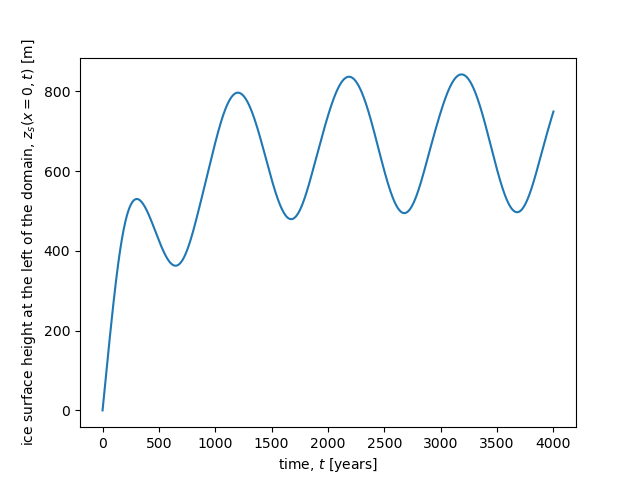

In [9]:
%matplotlib widget

plt.figure()
plt.plot(t[::10],H_varying_t[::10,0])
plt.xlabel('time, $t$ [years]')
plt.ylabel('ice surface height at the left of the domain, $z_s(x=0,t)$ [m]');

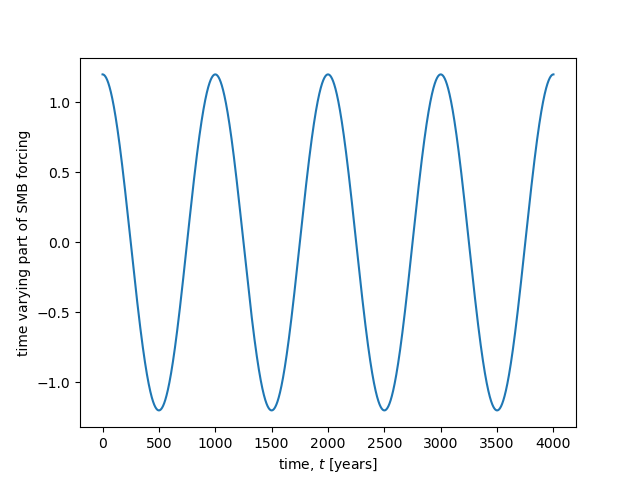

In [10]:
plt.figure()
plt.plot(t[::10],elx_variability[::10])
plt.xlabel('time, $t$ [years]')
plt.ylabel('time varying part of SMB forcing');

Text(0.5, 0, 'time varying part of SMB forcing')

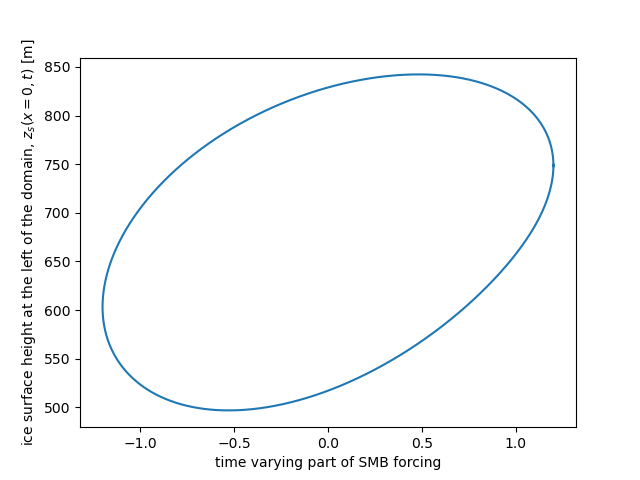

In [14]:
plt.figure()
plt.plot(elx_variability[-100000:], H_varying_t[-100000:,0]);
plt.ylabel('ice surface height at the left of the domain, $z_s(x=0,t)$ [m]');
plt.xlabel('time varying part of SMB forcing')

In [8]:
animate_ice_model_results(x, t, H_varying_t)

In [23]:
t.size

50000

In [33]:
one_cycle = int(1000/dt)

600.0 out of 10000 years
1200.0 out of 10000 years
1800.0 out of 10000 years
2400.0 out of 10000 years
3000.0 out of 10000 years
3600.0 out of 10000 years
4200.0 out of 10000 years
4800.0 out of 10000 years
5400.0 out of 10000 years
6000.0 out of 10000 years
6600.0 out of 10000 years
7200.0 out of 10000 years
7800.0 out of 10000 years
8400.0 out of 10000 years
9000.0 out of 10000 years
9600.0 out of 10000 years
600.0 out of 10000 years
1200.0 out of 10000 years
1800.0 out of 10000 years
2400.0 out of 10000 years
3000.0 out of 10000 years
3600.0 out of 10000 years
4200.0 out of 10000 years
4800.0 out of 10000 years
5400.0 out of 10000 years
6000.0 out of 10000 years
6600.0 out of 10000 years
7200.0 out of 10000 years
7800.0 out of 10000 years
8400.0 out of 10000 years
9000.0 out of 10000 years
9600.0 out of 10000 years
600.0 out of 10000 years
1200.0 out of 10000 years
1800.0 out of 10000 years
2400.0 out of 10000 years
3000.0 out of 10000 years
3600.0 out of 10000 years
4200.0 out of 1

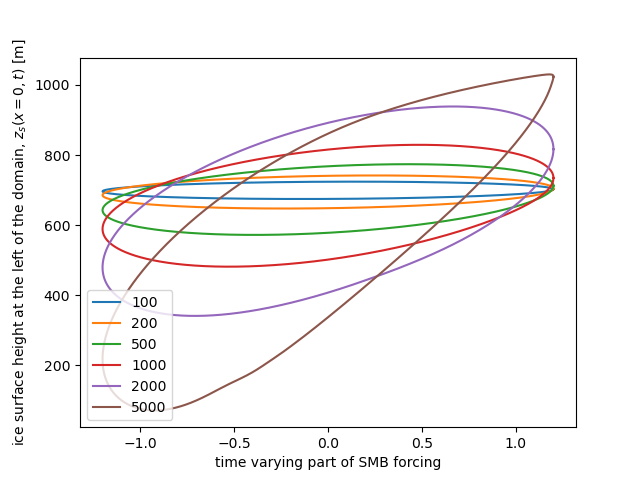

In [37]:
periods = [100, 200, 500, 1000, 2000, 5000]
plt.figure()

for period in periods:
    H_varying_t, x, t, q_varying_t, elx_variability = sia_time_varying(plot = False, T = 10000, period = period, amplitude = 1.2, dx = 1000, dt = 0.02)

    dt = t[1] - t[0]
    one_cycle = int(period/dt)
    plt.plot(elx_variability[-one_cycle:], H_varying_t[-one_cycle:,0], label = period);
    plt.ylabel('ice surface height at the left of the domain, $z_s(x=0,t)$ [m]');
    plt.xlabel('time varying part of SMB forcing')
plt.legend(loc = 'lower left')

In [1]:
H_varying_t, x, t, q_varying_t, elx_variability = sia_time_varying(print_period = 60000, period = 3000, T = 10000, amplitude = 1.2, dt = 0.02, dx = 500, plot = False)
animate_ice_model_results(x, t[::2], H_varying_t[::2], interval_between_timesteps = 2000)


NameError: name 'sia_time_varying' is not defined

Text(0.5, 0, 'time varying part of SMB forcing')

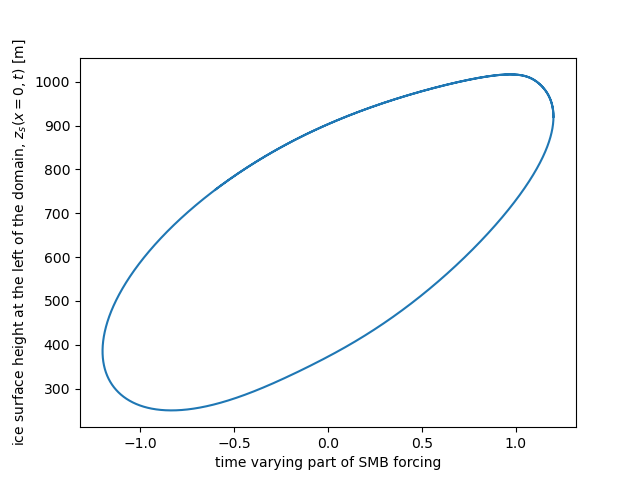

In [75]:
plt.figure()
plt.plot(elx_variability[-200000:], H_varying_t[-200000:,0]);
plt.ylabel('ice surface height at the left of the domain, $z_s(x=0,t)$ [m]');
plt.xlabel('time varying part of SMB forcing')

## 3. Allow the bed topography to vary

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def sia_bed(A = 24*10**(-25) * 365*24*60*60,
       T = 3000,
       dt = 0.004,
       dx = 200,
       X = 40000,
       b0 = 10**(-4), 
       elx = 1/3,
       plot = True,
       print_period = 30000,
       frequency = 0.001,
       amplitude = 0,
       bed_slope = 0):

    t = np.linspace(0,T,round(T/dt))  # the time grid, units [years]
    Lt = t.size                       # record the length of the time grid for use later

    x = np.linspace(0,X,round(X/dx))  # spatial grid, units [m]
    Lx = x.size                       # record the length of the spatial grid for use later


    x_stag = x[0:-1] + 0.5*dx

    n = 3.0                              # The flow law exponent
    rho = 917                            # ice density,  units [kg/m^3]
    g = 10                               # acceleration due to gravity, units [m/s^2]
    e = 0.0001  

    H = np.zeros((Lt,Lx))             # pre-allocate the H array

    H[0,:] = e                        # define initial conditions for H  
    
    zb = bed_slope * x - bed_slope*X
    
    elx_variability = X*elx*amplitude * np.cos(2 * np.pi * frequency * t) 
    
    ### the main loop
    for timestep in np.arange(1,Lt):

        # only print a message when the remainder of the timestep number and `print_period` is zero. i.e. if print_period = 30000, this prints a message very 30,000th timestep.
        if timestep % print_period == 0:    
            print(f'{t[timestep]:.1f} out of {T} years')

        # save the old thickness vector
        H_old  = H[timestep-1,:]
 
        
        # (1) compute H on the staggered grid
        H_stag = (H_old[1:] + H_old[:-1])/2

        # (2) compute the surface slope on the staggered grid.
        zs = zb + H_old
        alpha = -(zs[1:] - zs[:-1])/dx 
 
        
        # (3) compute the flux on the staggered grid
        q = 2*A/(n+2) * (rho * g * alpha)**n * H_stag**(n+2)  

        # compute b
        b = b0 * (  X*elx + elx_variability[timestep]  -  x  ) 
        
        # (4) compute the ice thickness at the current time step
        H[timestep,1:-1] = np.maximum(e, H_old[1:-1] + dt * ( b[1:-1]  - (q[1:]-q[0:-1])/dx ))    
 
        # apply the boundary conditions at x = 0 and x = X
        H[timestep,0] = H[timestep,1]
        H[timestep,-1] = e

    # save the flux
    q_final = q
    
    
    # plot unless plot == False
    if plot:
        fig,ax = plt.subplots(ncols=3, figsize=(20,10))
        
        ax[0].plot(x,np.transpose(zb+H[0:-1:print_period,:]), label = 'surface');
        ax[0].plot(x,zb, label = 'bed');
        #ax[0].legend()
        ax[0].set_xlabel('distance, $x$ [m]')
        ax[0].set_ylabel('ice surface height, $z_s(x)$ [m]')

        ax[1].plot(t[0:-1:print_period],np.transpose(zb[0]+H[0:-1:print_period,0]), label = 'ice divide height');
        ax[1].set_xlabel('time, $t$ [years]')
        ax[1].set_ylabel('ice surface height at the left of the domain, $z_s(x=0,t)$ [m]')
        
        ax[2].plot(t[0:-1:print_period],np.transpose(elx_variability[0:-1:print_period]), label = 'equilibrium line position');
        ax[2].set_xlabel('time, $t$ [years]')
        ax[2].set_ylabel('elx_variability [m]')
        
        plt.show()
        
        zs = H+zb
     
    return H, x, t, q_final, elx_variability, zb, zs

120.0 out of 4000 years
240.0 out of 4000 years
360.0 out of 4000 years
480.0 out of 4000 years
600.0 out of 4000 years
720.0 out of 4000 years
840.0 out of 4000 years
960.0 out of 4000 years
1080.0 out of 4000 years
1200.0 out of 4000 years
1320.0 out of 4000 years
1440.0 out of 4000 years
1560.0 out of 4000 years
1680.0 out of 4000 years
1800.0 out of 4000 years
1920.0 out of 4000 years
2040.0 out of 4000 years
2160.0 out of 4000 years
2280.0 out of 4000 years
2400.0 out of 4000 years
2520.0 out of 4000 years
2640.0 out of 4000 years
2760.0 out of 4000 years
2880.0 out of 4000 years
3000.0 out of 4000 years
3120.0 out of 4000 years
3240.0 out of 4000 years
3360.0 out of 4000 years
3480.0 out of 4000 years
3600.0 out of 4000 years
3720.0 out of 4000 years
3840.0 out of 4000 years
3960.0 out of 4000 years


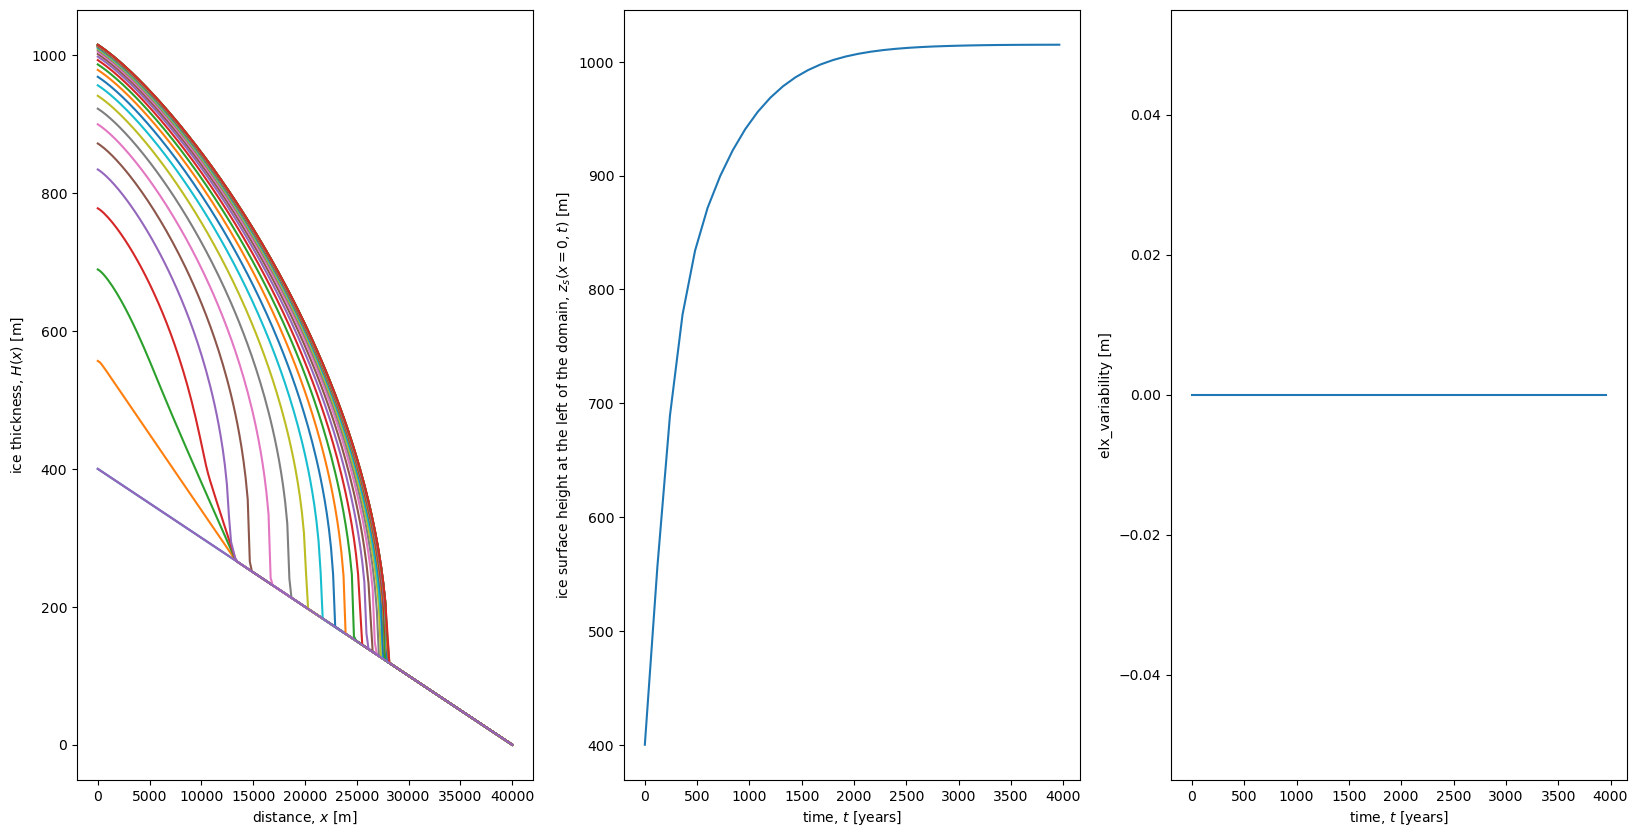

In [11]:
H, x, t, q_final, elx_variability, zb, zs = sia_bed(T = 4000, bed_slope = -0.01)